# Homework 3

**Due Date**: 4/6/25 by 8pm on Canvas

In this homework assignment, you are going to implement your own perceptron classifier. We will do this using native Python (i.e., no NumPy) for the most part. The exception is [Matplotlib](https://matplotlib.org/), which we will use to visualize our model.

You can work on this by yourself or with one other person in the class. If you are working as a group, only one person needs to submit the assignment on Canvas, but make sure to write who you worked with as a submission comment!

## Installing Libraries

Machine learning in Python has a plethora of popularly used libraries. We can install these library packages within the Jupyter Notebooks itself. Just run the cell below and it should download and install them to your computer. You only need to run this cell one time. After the package has been installed, feel free to change the cell type below from "Code" to "Raw" so it doesn't run this again.

In [2]:
%pip install matplotlib

## Imports

Let's begin by importing all the necessary library modules for this assignment.

In [3]:
import matplotlib.pyplot as plt
import random

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## Auxiliary Functions

There are a few auxiliary functions that we will use for this assignment:

- `gen_data` allows us to generate `n` samples as the dataset
    - Data samples are generated as 2D data
    - The dataset has the datatype `[([float], int)]`
    - One single sample in the dataset has the datatype `([float], int)`, where the first element (`[float]`) are the features and the second element (`int`) is the label (either -1 or +1)
- `lift` takes the features in a 2D dataset and "lifts" the data to 3D by appending a 1 at the end
- `display_data` handles creating the visual plot of our `dataset` and the hyperplane defined by the `weight` vector
    - The `show_weight` flag allows us to toggle displaying the actual `weight` on the screen

In [4]:
def gen_data(n, max=10):
    dataset = []
    pt1 = [random.uniform(0,max), random.uniform(0,max)]
    pt2 = [random.uniform(0,max), random.uniform(0,max)]
    a = (pt2[1] - pt1[1]) / (pt2[0] - pt1[0])
    b = (pt1[1] - a * pt1[0])
    for i in range(n):
        X = [random.uniform(0,max), random.uniform(0,max)]
        y = +1 if X[1] <= (a * X[0] + b) else -1
        dataset.append((X, y))
    return dataset


def lift(dataset):
    c = dataset[:]
    for i in range(len(c)):
        c[i][0].append(1.0)
    return c


def display_data(dataset, weight, show_weight=False):
    xs_pos = [X[0] for X,y in dataset if y == +1]
    ys_pos = [X[1] for X,y in dataset if y == +1]
    xs_neg = [X[0] for X,y in dataset if y == -1]
    ys_neg = [X[1] for X,y in dataset if y == -1]
    
    plt.plot(xs_pos, ys_pos, 'ro', label='+1')
    plt.plot(xs_neg, ys_neg, 'bs', label='-1')
    plt.plot(0, 'g--', label='Hyperplane')

    if show_weight:
        plt.plot(weight[0], weight[1], 'y^', label='Weight')
    
    plt.axhline(0, color='black', linewidth=1.5)
    plt.axvline(0, color='black', linewidth=1.5)
    plt.axline((0, -weight[2] / weight[1]), (1, (-weight[0] / weight[1]) + (-weight[2] / weight[1])), color='green', linestyle='--')
    
    plt.grid(True)
    plt.legend()
    plt.show()

## Math Helpers

Before we can implement the actual perceptron, we need a number of math helper functions.

### `sign`

This function is straightforward. Given a single integer `n`, return the sign of that number. In other words, a positive `n` returns a +1, while a negative `n` returns a -1.

### `dot_product`

Given the two lists (`weight` and `feature`), this function needs to compute their "dot product." Although this may sound intimidating, the actual process is simple. For each pair of numbers in the vectors, you need to multiply them. Then, add up these products and you have your result: a single number.

For example, suppose:

$$
\overrightarrow{w} = \left< 3,1,-4 \right>
$$

$$
\overrightarrow{x} = \left< 2,5,1 \right>
$$

Then, to calculate their dot product ($\overrightarrow{w} \cdot \overrightarrow{x}$), we do:

$$
\begin{align}
\overrightarrow{w} \cdot \overrightarrow{x} &= (3)(2) + (1)(5) + (-4)(1) \\
                                            &= 6 + 5 + (-4) \\
                                            &= 7 \\
\end{align}
$$

Note: in lecture, I used the more general matrix notation for this instead ($\mathbf{w}^{\text{T}} \mathbf{x}$). Because of the way the data is structured for the perceptron, it ends up being equivalent to the dot product. This is not true in general, however.

### `add_lists`

We also need a way to add the values in two lists together. Given the two lists (`weight` and `feature`), this function is expected to produce a new list containing the sums.

For example, suppose:

```Python
weight = [3,1,-4]
feature = [2,5,1]
```

Then, this function should be able to produce the output list: `[5,6,-3]`.

### `scalar_mult`

Finally, we need a function that is able to handle scalar multiplication. Again, though this may sound intimidating, it's pretty easy. The function has two inputs: `label` which is an integer and `feature` which is a list of floating-point values. All we need to do is multiply each element in `feature` by `label` and return these results as a list.

For example, if `label = -1` and `feature = [2,5,1]`, then this function should output the list: `[-2,-5,-1]`.

In [5]:
def sign(n):
    # TODO: write your solution here
    if n >= 0:
        return 1
    else:
        return -1

def dot_product(weight, feature):
    # TODO: write your solution here
    result = 0
    for i in range(len(weight)):
        result += weight[i] * feature[i]
    return result

def add_lists(weight, feature):
    # TODO: write your solution here
    result = []
    for i in range(len(weight)):
        result.append(weight[i] + feature[i])
    return result

def scalar_mult(label, feature):
    # TODO: write your solution here
    result = []
    for i in range(len(feature)):
        result.append(label * feature[i])
    return result
    

## Perceptron

With the above completed, we are now ready to create our perceptron! We need two functions for this.

### `classify`

This function is meant to implement the formula:

$$
\mbox{sign}\left( \mathbf{w}^{\text{T}} \mathbf{x} \right)
$$

Which, equivalenty for this classifier, is:

$$
\mbox{sign}\left( \overrightarrow{w} \cdot \overrightarrow{x} \right)
$$

### `perceptron`

We're here: the actual ML algorithm! Implement the perceptron algorithm using the pseudocode below as a guide:

$$
\begin{align}
&\text{Initialize } \overrightarrow{w} \text{ to the zero vector} \\
&\text{While the model is misclassifying the data} \\
&\text{\quad For each } \left(\overrightarrow{x},y\right) \text{ in } \mathcal{D} \\
&\text{\qquad If } \left(\overrightarrow{x},y\right) \text{ is being misclassified} \\
&\text{\qquad \quad Update } \overrightarrow{w} \\
&\text{Return } \overrightarrow{w} \\
\end{align}
$$

In [8]:
def classify(weight, feature):
    # TODO: write your solution here
    return sign(dot_product(weight, feature))

def perceptron(dataset):
    # TODO: write your solution here
    feature_length = len(dataset[0][0])
    weight = [0] * feature_length

    #repeat until convergence
    updated = True
    while updated:
        updated = False
        
    for feature, label in dataset:
            prediction = classify(weight, feature)
            if prediction != label:
                # Update weights: w = w + y * x
                weight = add_lists(weight, scalar_mult(label, feature))
                updated = True

    return weight

## Demo

The moment of truth! Let's see how well our little perceptron performs. I recommend starting off by testing the fixed datasets. Start with just 2 samples, and if that works, try it with 3, then 4, etc. If you manage to classify all the data correctly, try generating random data by uncommenting the call to `gen_data`. Try passing different numbers to the function. Don't forget, you can also set `show_weight=True` for the `display_data` function call if you want to see where the weight vector is.

By the way, if you want to see how the weights adjust as the perceptron learns the hyperplane, you can add a call to `display_data` in your `perceptron` loop. Fair warning: you might end up producing **A LOT** of graphs 🙀

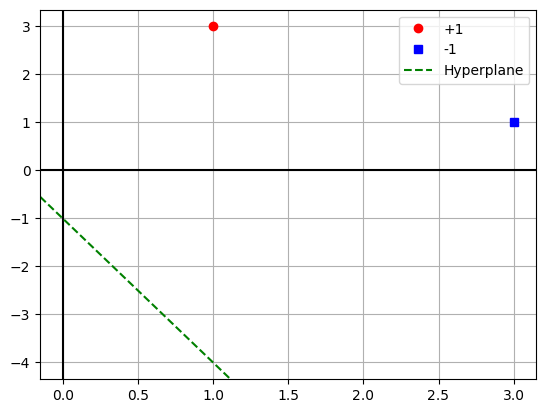

In [9]:
dataset = [([1,3], +1), ([3,1], -1)]
# dataset = [([1,3], +1), ([3,1], -1), ([2,2], +1)]
# dataset = [([1,3], +1), ([3,1], -1), ([2,2], +1), ([4.5,2.5], -1)]
# dataset = [([1,3], +1), ([3,1], -1), ([2,2], +1), ([4.5,2.5], -1), ([3.5,4.2], -1)]
# dataset = [([1,3], +1), ([3,1], -1), ([2,2], +1), ([4.5,2.5], -1), ([3.5,4.2], -1), ([0.53, -5.41], +1)]
# dataset = gen_data(25)
weight = perceptron(lift(dataset))
display_data(dataset, weight)